In [1]:
import matplotlib.pyplot as plt
import acm.observables.emc as emc
from pathlib import Path
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import torch
plt.style.use(['science','no-latex'])

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [5]:

select_mocks={'cosmo_idx': [0], 'hod_idx': [30,],}

In [6]:
stat_map = {
    'tpcf': emc.GalaxyCorrelationFunctionMultipoles(
        select_mocks=select_mocks,
    ),
    'bk': emc.GalaxyBispectrumMultipoles(
        select_mocks=select_mocks,
    ),
    'pk' : emc.GalaxyPowerSpectrumMultipoles(
        select_mocks=select_mocks,
    ),
    'minkowski': emc.MinkowskiFunctionals(
        select_mocks=select_mocks,
    ),
    'wst': emc.WaveletScatteringTransform(
        select_mocks=select_mocks,
    ),
    'dsc_pk': emc.DensitySplitPowerSpectrumMultipoles(
        select_mocks=select_mocks,
    ),
    'wp': emc.GalaxyProjectedCorrelationFunction(
        select_mocks=select_mocks,
    ),
    'pdf': emc.GalaxyOverdensityPDF(
        select_mocks=select_mocks,
    ),
    'ngal': emc.GalaxyNumberDensity(
        select_mocks=select_mocks,
    ),
    'mst': emc.MinimumSpanningTree(
        select_mocks=select_mocks,
    ),
    'vg_voids': emc.VoxelVoidGalaxyCorrelationFunctionMultipoles(
        select_mocks=select_mocks,
    ),
    'dt_voids': emc.DTVoidGalaxyCorrelationFunctionMultipoles(
        select_mocks=select_mocks,
    ),
    'cumulant': emc.CumulantGeneratingFunction(
        select_mocks=select_mocks,
    ),
}

GalaxyCorrelationFunctionMultipoles
GalaxyBispectrumMultipoles
GalaxyPowerSpectrumMultipoles
MinkowskiFunctionals
WaveletScatteringTransform
DensitySplitPowerSpectrumMultipoles
GalaxyProjectedCorrelationFunction
GalaxyOverdensityPDF
GalaxyNumberDensity
MinimumSpanningTree
VoxelVoidGalaxyCorrelationFunctionMultipoles
DTVoidGalaxyCorrelationFunctionMultipoles
CumulantGeneratingFunction


In [7]:

import torch.func as func

def get_gradient(statistic):
    fiducial_parameters = stat_map[statistic].lhc_x
    fiducial_parameters = torch.tensor(fiducial_parameters.astype(np.float32), requires_grad=True,).unsqueeze(0)
    def model_fn(x_batch):
        # Add batch dimension for the model
        return stat_map[statistic].model.get_prediction(x_batch)
    return func.jacrev(model_fn)(fiducial_parameters).detach().squeeze().numpy()

def get_full_gradients(statistics):
    return np.vstack([get_gradient(stat) for stat in statistics],)

def get_precision_matrix(full_covariance_vector):
    if full_covariance_vector.shape[1] == 1:
        # For 1D case, calculate variance manually and force a 1x1 matrix
        variance = np.var(full_covariance_vector, ddof=1)
        covariance_matrix = np.array([[variance]])
    else:
        covariance_matrix = np.cov(full_covariance_vector.T)
    correction = stat_map['tpcf'].get_covariance_correction(
        n_s=full_covariance_vector.shape[0],
        n_d=len(covariance_matrix),
        n_theta=20,
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)
    return precision_matrix


def get_fisher_log_det(statistics,):
    full_covariance_vector = np.hstack([stat_map[stat].small_box_y for stat in statistics])
    precision_matrix = get_precision_matrix(full_covariance_vector)
    gradients = get_full_gradients(statistics)
    fisher_matrix = np.dot(gradients.T, np.dot(precision_matrix, gradients))
    sign, fisher_log_det = np.linalg.slogdet(fisher_matrix)
    return fisher_log_det

In [8]:
total_fisher = get_fisher_log_det(['bk', 'tpcf'])

In [9]:

def precompute_derivatives_and_covariance(statistics=['tpcf', 'bk']):
    precomputed = {}
    precomputed['derivatives'] = {}
    for stat_name in statistics:
        precomputed['derivatives'][stat_name] = get_gradient(stat_name)
    
    precomputed['covariance_data'] = {}
    for stat_name in statistics:
        precomputed['covariance_data'][stat_name] = stat_map[stat_name].small_box_y
    
    precomputed['bin_counts'] = {
        stat_name: precomputed['derivatives'][stat_name].shape[1] 
        for stat_name in statistics
    }
    return precomputed

In [10]:
precomputed = precompute_derivatives_and_covariance(statistics=['tpcf', 'bk'])

In [11]:
precomputed['derivatives']['tpcf'].shape

(150, 20)

In [12]:

precomputed['covariance_data']['tpcf'].shape

(1786, 150)

In [105]:
def generate_augmented_gradients(selected_bin_gradients, available_bin_gradients):

    if selected_bin_gradients.shape[0] == 0:
        return available_bin_gradients
    else:
        return np.array([
            np.vstack([selected_bin_gradients, available_bin_gradients[i]])
            for i in range(len(available_bin_gradients))
        ])


def compute_precision_matrices(selected_bin_data, available_bin_data):
    if selected_bin_data.shape[1] == 0:
        covariance_mocks = available_bin_data
    else:
        covariance_mocks = np.array([
            np.hstack([selected_bin_data, available_bin_data[i]])
            for i in range(len(available_bin_data))
        ])
    n_mocks = covariance_mocks.shape[1]
    n_dim = covariance_mocks.shape[-1]
    n_options = len(covariance_mocks)
    correction = stat_map['tpcf'].get_covariance_correction(
        n_s=n_mocks,
        n_d=n_dim,
        n_theta=20,
        method='percival',
    )
    
    precision_matrices = np.zeros((n_options, n_dim, n_dim))
    for i in range(n_options):
        covariance_matrix = np.atleast_2d(np.cov(covariance_mocks[i].T))
        precision_matrices[i] = np.linalg.inv(correction * covariance_matrix)
    return precision_matrices 

def get_batch_fisher_matrices(gradients, precision_matrices):
    temp = np.einsum('mij,mjk->mik', precision_matrices, gradients)
    return np.einsum('mki,mij->mkj', gradients.transpose(0, 2, 1), temp)

def get_batch_fisher_information(fisher_matrices):
    _, logabsdet = np.linalg.slogdet(fisher_matrices)
    return logabsdet

def get_maximum_fisher_idx(selected_bin_gradients, available_bin_gradients, selected_bin_data, available_bin_data):
    augmented_gradients = generate_augmented_gradients(
        selected_bin_gradients,
        available_bin_gradients[:,None,:],
    )
    precision_matrices = compute_precision_matrices(
        selected_bin_data,
        available_bin_data.T[...,None],
    )
    fisher_matrices = get_batch_fisher_matrices(augmented_gradients, precision_matrices)
    fisher_information = get_batch_fisher_information(fisher_matrices)
    max_fisher_idx = np.argmax(fisher_information)
    return max_fisher_idx, fisher_information[max_fisher_idx]

current_gradients = precomputed['derivatives']['tpcf']
possible_gradients = precomputed['derivatives']['bk']

current_covariance_mocks = precomputed['covariance_data']['tpcf']
possible_covariance_mocks = precomputed['covariance_data']['bk']


get_maximum_fisher_idx(
    selected_bin_gradients=current_gradients,
    available_bin_gradients=possible_gradients,
    selected_bin_data=current_covariance_mocks,
    available_bin_data=possible_covariance_mocks,
)

(171, 49.84058512183652)

In [118]:
import time

def greedy_bin_selection_vectorized(precomputed, max_bins=10):
    derivatives = precomputed['derivatives']
    covariance_data = precomputed['covariance_data']
    statistics = list(derivatives.keys())
    
    available_bins = {stat: list(range(derivatives[stat].shape[0])) for stat in statistics}
    selected_bins = {stat: [] for stat in statistics}
    
    n_params = derivatives[statistics[0]].shape[1]
    selected_bin_gradients = np.zeros((0, n_params))
    selected_bin_data = np.zeros((covariance_data[statistics[0]].shape[0], 0))
    
    current_fisher = float('-inf')
    all_fisher_values = []
    total_selected_bins = 0
    
    while total_selected_bins < max_bins:
        best_stat = None
        best_idx = None
        best_fisher = current_fisher
        
        for stat_name in statistics:
            if not available_bins[stat_name]:
                continue
                
            stat_indices = available_bins[stat_name]
            stat_gradients = derivatives[stat_name][stat_indices]
            stat_covs = covariance_data[stat_name][:, stat_indices]

            max_idx_local, max_fisher = get_maximum_fisher_idx(
                selected_bin_gradients=selected_bin_gradients,
                available_bin_gradients=stat_gradients,
                selected_bin_data=selected_bin_data,
                available_bin_data=stat_covs,  
            )
            
            bin_idx = stat_indices[max_idx_local]
            
            if max_fisher > best_fisher:
                best_fisher = max_fisher
                best_stat = stat_name
                best_idx = bin_idx
        
        improvement = best_fisher - current_fisher
        if improvement < 1e-6 or best_stat is None:
            print("No significant improvement found, stopping early")
            break
            
        selected_bins[best_stat].append(best_idx)
        available_bins[best_stat].remove(best_idx)
        
        bin_gradient = derivatives[best_stat][best_idx:best_idx+1]
        bin_data = covariance_data[best_stat][:, best_idx:best_idx+1]
        
        if total_selected_bins == 0:
            selected_bin_gradients = bin_gradient
            selected_bin_data = bin_data
        else:
            selected_bin_gradients = np.vstack([selected_bin_gradients, bin_gradient])
            selected_bin_data = np.hstack([selected_bin_data, bin_data])
        
        total_selected_bins += 1
        current_fisher = best_fisher
        all_fisher_values.append(current_fisher)
        
        if total_selected_bins % 5 == 0 or total_selected_bins == 1 or total_selected_bins == max_bins:
            print(f"Selected {total_selected_bins}/{max_bins} bins, Fisher: {current_fisher:.4f}")
            distribution = ", ".join([f"{stat}: {len(bins)}" for stat, bins in selected_bins.items()])
            print(f"Distribution: {distribution}")
            print(f"Added {best_stat}:{best_idx} with improvement {improvement:.4f}")
    
    return selected_bins, current_fisher, all_fisher_values

def run_optimization_vectorized(statistics=['tpcf', 'bk'], max_bins=100):
    print(f"Precomputing data for statistics: {statistics}")
    precomputed_data = precompute_derivatives_and_covariance(statistics)
    
    print(f"\nRunning greedy selection with max_bins={max_bins}")
    selected_bins, final_fisher, all_fisher_values = greedy_bin_selection_vectorized(precomputed_data, max_bins=max_bins)
    
    print("\nFinal selection:")
    for stat, bins in selected_bins.items():
        print(f"{stat}: {len(bins)} bins selected")
    print(f"Total: {sum(len(bins) for bins in selected_bins.values())} bins")
    print(f"Final Fisher log-determinant: {final_fisher:.4f}")
    
    return selected_bins, final_fisher, all_fisher_values

In [ ]:
to_combine = ['wst','tpcf', 'bk', 'wp', 'dsc_pk','dt_voids']# 'ngal'] 
selected_bins, final_fisher, all_fisher_values = run_optimization_vectorized(to_combine, max_bins=200)

Precomputing data for statistics: ['wst', 'tpcf', 'bk', 'wp', 'dsc_pk', 'dt_voids']

Running greedy selection with max_bins=200
Selected 1/200 bins, Fisher: -562.6256
Distribution: wst: 0, tpcf: 1, bk: 0, wp: 0, dsc_pk: 0, dt_voids: 0
Added tpcf:0 with improvement inf
Selected 5/200 bins, Fisher: -391.9544
Distribution: wst: 1, tpcf: 2, bk: 0, wp: 1, dsc_pk: 0, dt_voids: 1
Added dt_voids:3 with improvement 36.7196
Selected 10/200 bins, Fisher: -221.4568
Distribution: wst: 3, tpcf: 4, bk: 0, wp: 1, dsc_pk: 0, dt_voids: 2
Added dt_voids:5 with improvement 32.5652
Selected 15/200 bins, Fisher: -65.9389
Distribution: wst: 5, tpcf: 5, bk: 0, wp: 1, dsc_pk: 1, dt_voids: 3
Added tpcf:101 with improvement 30.4017
Selected 20/200 bins, Fisher: 75.4364
Distribution: wst: 5, tpcf: 5, bk: 4, wp: 1, dsc_pk: 2, dt_voids: 3
Added dsc_pk:30 with improvement 27.0434
Selected 25/200 bins, Fisher: 85.2198
Distribution: wst: 7, tpcf: 6, bk: 4, wp: 2, dsc_pk: 2, dt_voids: 4
Added wst:3 with improvement 1.7

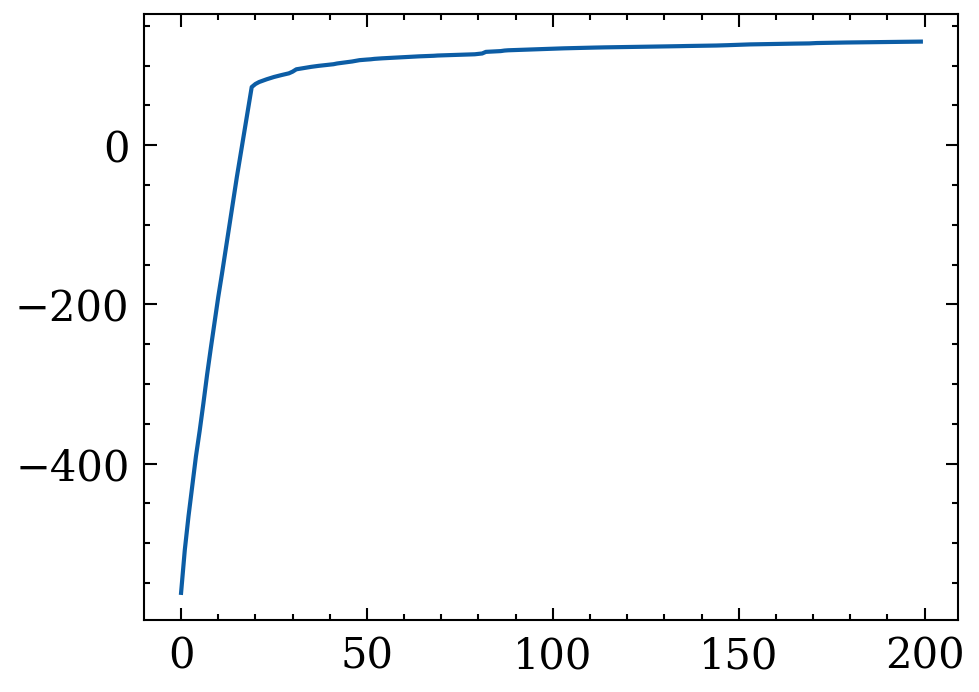

In [ ]:
plt.plot(all_fisher_values)
#plt.axhline(y=total_fisher, color='r', linestyle='--', label='Final log-det')
#plt.axvline(x=2.*total_fisher, linestyle='dashed',)
#plt.axvline(x=75, linestyle='dashed',)
#plt.ylim(30,total_fisher*1.1)
plt.show()

In [21]:
#selected_bins, final_log_det, all_log_dets = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'wp', 'wst',], max_bins=250)

In [22]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'minkowski'], max_bins=100)

In [23]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk'], max_bins=100)

In [127]:
from sunbird.inference.pocomc import PocoMCSampler
from sunbird.inference.priors import Yuan23, AbacusSummit
from sunbird import setup_logging

import acm.observables.emc as emc

from pathlib import Path
import numpy as np
import argparse

def get_priors(cosmo=True, hod=True):
    stats_module = 'scipy.stats'
    priors, ranges, labels = {}, {}, {}
    if cosmo:
        priors.update(AbacusSummit(stats_module).priors)
        ranges.update(AbacusSummit(stats_module).ranges)
        labels.update(AbacusSummit(stats_module).labels)
    if hod:
        priors.update(Yuan23(stats_module).priors)
        ranges.update(Yuan23(stats_module).ranges)
        labels.update(Yuan23(stats_module).labels)
    return priors, ranges, labels

In [132]:

from getdist import plots, MCSamples
def get_samples(chain):
    chain['labels']['w0_fld'] = r'w_0'
    chain['labels']['wa_fld'] = r'w_a'
    chain['labels']['omega_cdm'] = r'\omega_{cdm}'
    chain['labels']['sigma8_m'] = r'\sigma_8'
    chain['labels']['n_s'] = r'n_s'
    samples = MCSamples(
        samples=chain['samples'],
        weights=chain['weights'],
        names=chain['names'],
        ranges=chain['ranges'],
        labels=[chain['labels'][n] for n in chain['names']],
    )
    return samples

def run_chain(observables):

    priors, ranges, labels = get_priors(cosmo=True, hod=True)
    fixed_params = ['w0_fld', 'wa_fld', 'nrun', 'N_ur']
    add_emulator_error = True
    cosmo_idx, hod_idx = 0, 30
    for observable in observables:
        observable.select_mocks['cosmo_idx'] = cosmo_idx
        observable.select_mocks['hod_idx'] = hod_idx

    observable = emc.CombinedObservable(observables)

    data_x = observable.lhc_x
    data_x_names = observable.lhc_x_names
    data_y = observable.lhc_y

    covariance_matrix = observable.get_covariance_matrix(divide_factor=64)
    if add_emulator_error:
        emulator_error = observable.get_emulator_error()
        covariance_matrix += np.diag(emulator_error**2)

    correction = observable.get_covariance_correction(
        n_s=len(observable.small_box_y),
        n_d=len(covariance_matrix),
        n_theta=len(data_x_names) - len(fixed_params),
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)

    fixed_params = {key: data_x[data_x_names.index(key)]
                        for key in fixed_params}


    model = observable.model

    correction = observable.get_covariance_correction(
        n_s=len(observable.small_box_y),
        n_d=len(covariance_matrix),
        n_theta=len(data_x_names) - len(fixed_params),
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)

    fixed_params = {key: data_x[data_x_names.index(key)]
                        for key in fixed_params}


    model = observable.model
    sampler = PocoMCSampler(
        observation=torch.tensor(data_y),
        precision_matrix=precision_matrix,
        theory_model=model,
        fixed_parameters=fixed_params,
        priors=priors,
        ranges=ranges,
        labels=labels,
        ellipsoid=True,
    )

    sampler(vectorize=True, n_total=4096)

    chain = sampler.get_chain(flat=True)
    names = [param for param in sampler.priors.keys() if param not in sampler.fixed_parameters]
    chain = {**chain,
        'ranges': sampler.ranges,
        'names': names,
        'labels': sampler.labels,
    }
    samples = get_samples(chain)
    markers = {key: data_x[data_x_names.index(key)] for key in data_x_names if key not in fixed_params}
    return chain, samples, markers

In [133]:
fisher_stat_map = {}
for stat_str, stat in stat_map.items():
    if stat_str in to_combine:
        fisher_stat_map[stat_str] = stat.__class__(select_mocks=select_mocks, select_indices = selected_bins[stat_str])


GalaxyCorrelationFunctionMultipoles
GalaxyBispectrumMultipoles
MinkowskiFunctionals
WaveletScatteringTransform
DensitySplitPowerSpectrumMultipoles
GalaxyProjectedCorrelationFunction
DTVoidGalaxyCorrelationFunctionMultipoles


In [130]:
chain, samples, markers = run_chain([stat_map['ngal'], stat_map['tpcf'], stat_map['bk']])

GalaxyNumberDensity
GalaxyCorrelationFunctionMultipoles
GalaxyBispectrumMultipoles


Iter: 0it [00:00, ?it/s, beta=0, calls=0, ESS=512, logZ=0, logP=0, acc=0, steps=0, eff=0]/global/u1/c/cuesta/sunbird/sunbird/inference/pocomc.py:108: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  logl = np.asarray([-0.5 * diff[i] @ self.precision_matrix @ diff[i].T for i in range(len(theta))])
Iter: 48it [08:58, 11.21s/it, beta=1, calls=216064, ESS=3856, logZ=-64.6, logP=-28.3, acc=0.389, steps=17, eff=1]           

Removed no burn in


In [151]:
stat_constrained = ['tpcf','bk', 'wst', 'dsc_pk', 'wp', 'dt_voids']

In [152]:
#fisher_stat_map

In [ ]:
fisher_chain, fisher_samples, fisher_markers = run_chain(
    [stat_map['ngal'],] + [stat for stat in fisher_stat_map.values()]) 

GalaxyNumberDensity
GalaxyCorrelationFunctionMultipoles
GalaxyBispectrumMultipoles
WaveletScatteringTransform
DensitySplitPowerSpectrumMultipoles
GalaxyProjectedCorrelationFunction
DTVoidGalaxyCorrelationFunctionMultipoles


Iter: 5it [01:42, 20.55s/it, beta=9.06e-6, calls=1024, ESS=508, logZ=-1.11, logP=-5.25e+6, acc=1, steps=1, eff=1] eff=0.926] 
Iter: 48it [08:01, 15.12s/it, beta=1, calls=144640, ESS=2100, logZ=-50.3, logP=-6.59, acc=0.284, steps=25, eff=1]           

KeyboardInterrupt: 

<Figure size 1260x1134 with 0 Axes>

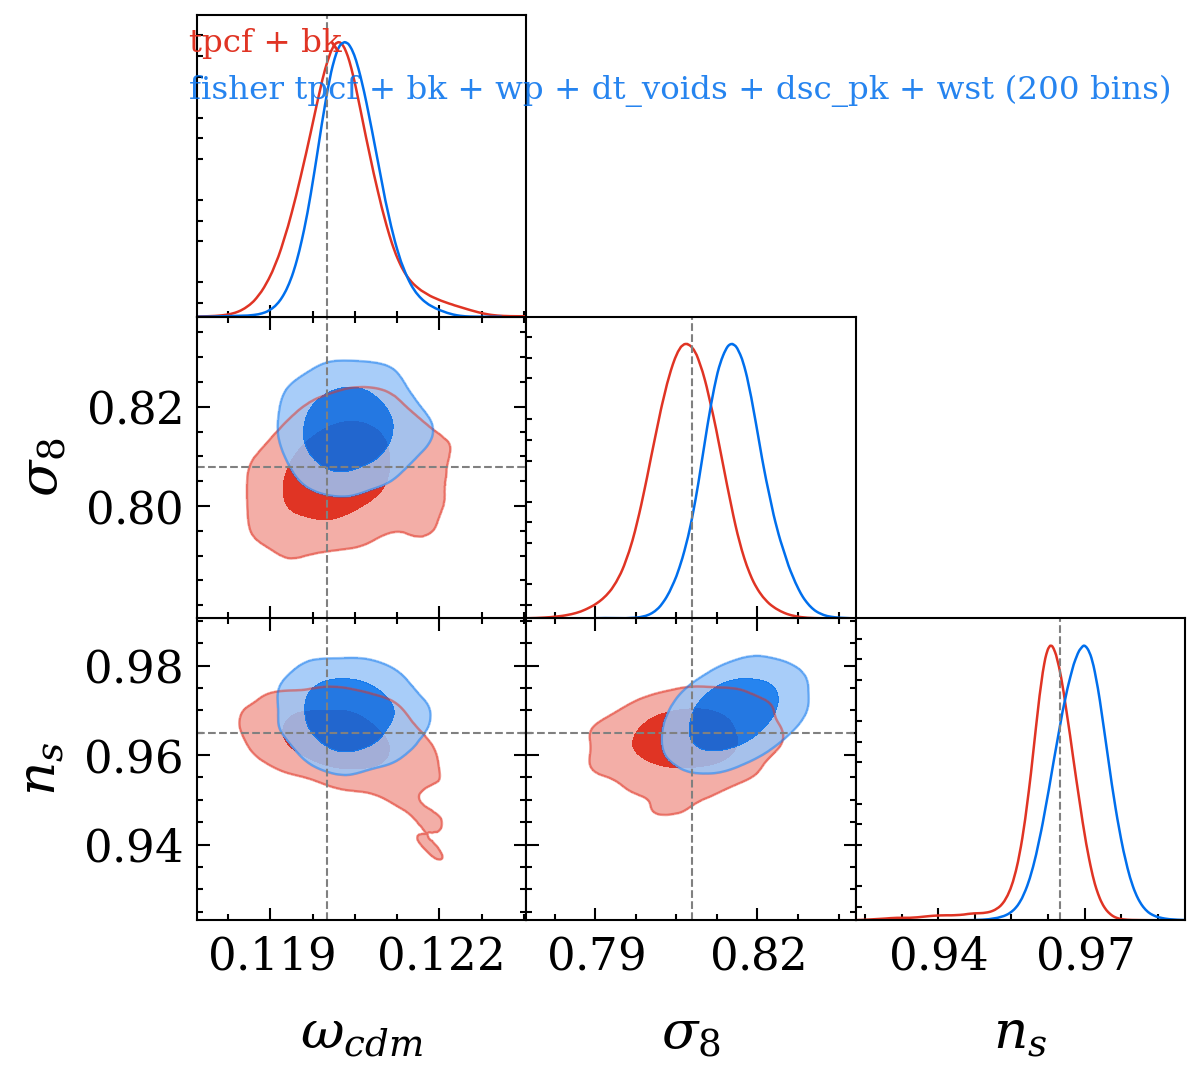

<Figure size 1260x1134 with 0 Axes>

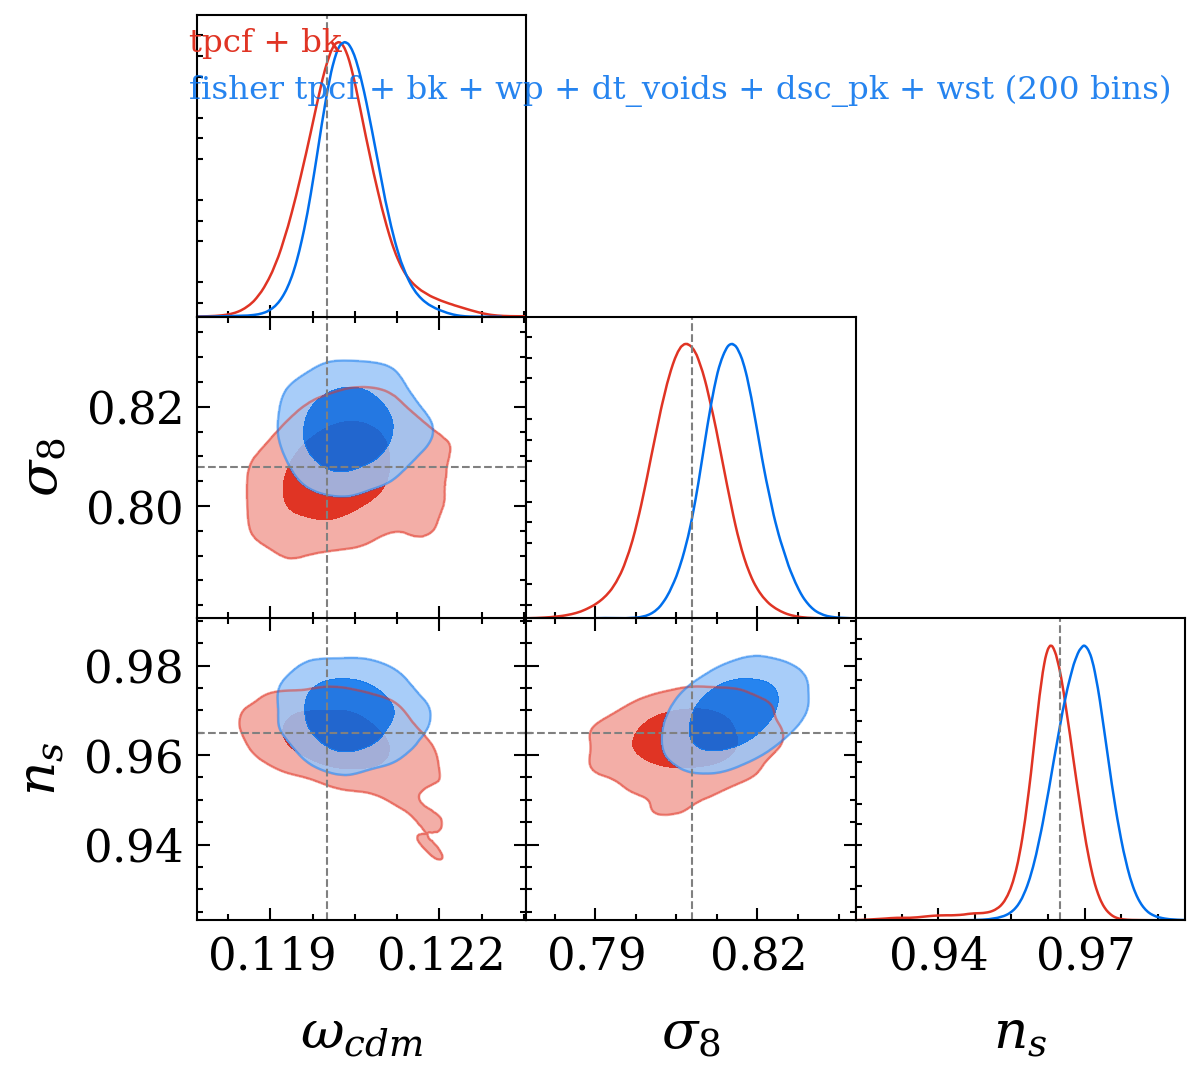

In [ ]:

# g = plots.get_single_plotter(width_inch=4)
g = plots.get_single_plotter(width_inch=4.2, ratio=4.5/5)
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = True
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 17

g.triangle_plot(
    roots=[
        samples,
        fisher_samples,
    ],
    legend_labels=[
        'tpcf + bk', 
        'greedy tpcf + bk + wp + dt_voids + dsc_pk + wst  + minkowski(200 bins)', 
    ],
    markers=markers,
    params=['omega_cdm', 'sigma8_m', 'n_s',], 
    filled=True,
)



<Figure size 1260x1134 with 0 Axes>

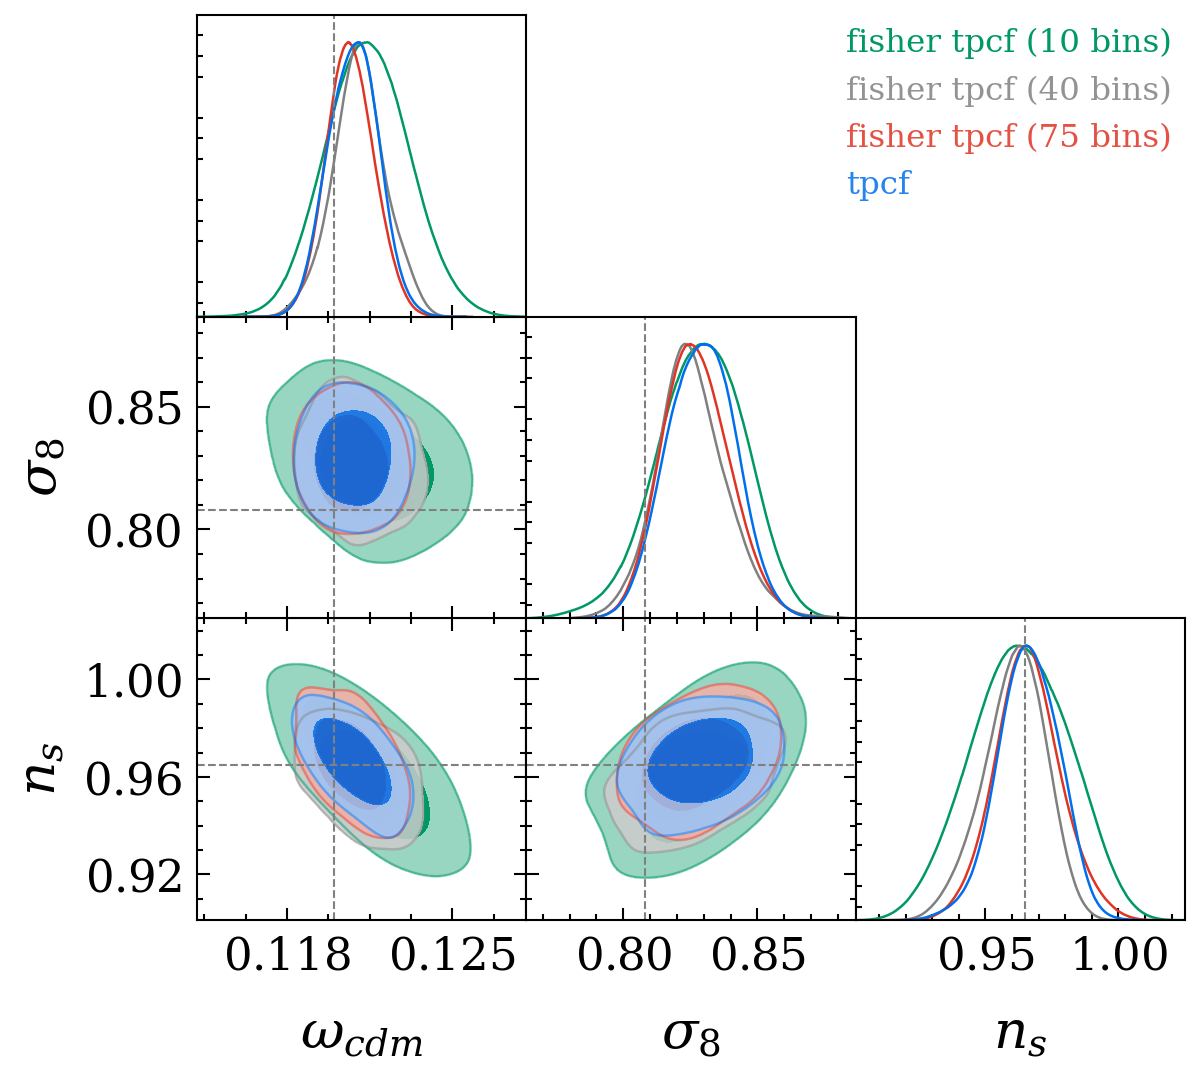

In [ ]:

# g = plots.get_single_plotter(width_inch=4)
g = plots.get_single_plotter(width_inch=4.2, ratio=4.5/5)
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = True
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 17

g.triangle_plot(
    roots=[
        fisher_samples_10,
        fisher_samples_40,
        fisher_samples,
        samples,
    ],
    legend_labels=[
        'fisher tpcf (10 bins)', 
        'fisher tpcf (40 bins)', 
        'fisher tpcf (75 bins)', 
        'tpcf', 
    ],
    markers=markers,
    params=['omega_cdm', 'sigma8_m', 'n_s',], 
    filled=True,
)

